(275, 2, 2035, 252)
[127 552   1   1   1]
Label ID: 1, Area: 4040 pixels, Centroid: (143, 310)
Label ID: 8, Area: 7234 pixels, Centroid: (127, 504)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


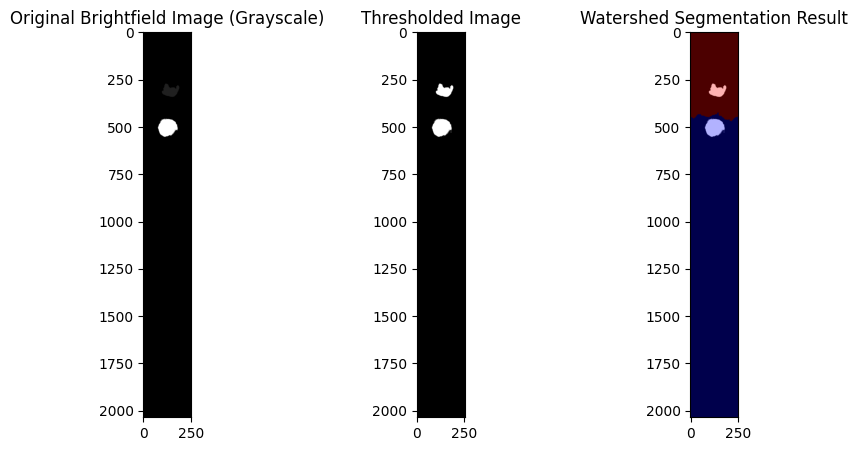

In [117]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tifffile

tifffile_image = tifffile.imread(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\trap_1_all_frames_series.tiff")
print(tifffile_image.shape)

# Load your fluorescent and brightfield images
fluorescent_image = tifffile_image[1, 1, :, :]
brightfield_image = tifffile_image[1, 0, :, :]


# Apply Otsu's thresholding
threshold = cv2.threshold(fluorescent_image, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]  
threshold = threshold.astype(np.uint8)

dist_transform = cv2.distanceTransform(threshold cv2.DIST_L2,3)
local_max_location = peak_local_max(dist_transform, min_distance=1)

markers, _ = ndi.label(local_max_location)


# Perform connected components analysis
analysis = cv2.connectedComponentsWithStats(threshold, 4, cv2.CV_32S) 
(totalLabels, label_ids, values, centroids) = analysis  # Using 'centroids' instead of 'centroid'
print(values[label])

# Minimum area threshold for filtering
min_area_threshold = 100  # Adjust as needed

# Print area, label ID, and centroids for each label, filtered by area
for label in range(1, totalLabels):  # Start from 1 to skip background label
    area = values[label][4]
    if area >= min_area_threshold:
        centroid = tuple(map(int, centroids[label]))
        print(f"Label ID: {label}, Area: {area} pixels, Centroid: {centroid}")"""

# Create an empty marker image
markers = np.zeros_like(threshold, dtype=np.int32)


# Assign labels as markers, filtered by area
for label in range(0, totalLabels):  
    area = values[label][4]
    if area >= min_area_threshold:
        markers[label_ids == label] = label
        
# Convert the marker image to 32-bit single-channel
markers = markers.astype(np.int32)

# Apply watershed segmentation
segmentation = skimage.segmentation.watershed(brightfield_image, markers)


# Plotting
plt.figure(figsize=(10, 5))

# Original Brightfield Image
plt.subplot(1, 3, 1)
plt.imshow(brightfield_image, cmap='gray')  # Displaying in grayscale
plt.title('Original Brightfield Image (Grayscale)')

# Thresholded Image
plt.subplot(1, 3, 2)
plt.imshow(threshold, cmap='gray')
plt.title('Thresholded Image')

# Watershed Segmentation Result
plt.subplot(1, 3, 3)
plt.imshow(overlay, cmap='gray')  # Displaying in grayscale
plt.title('Watershed Segmentation Result')

plt.show()


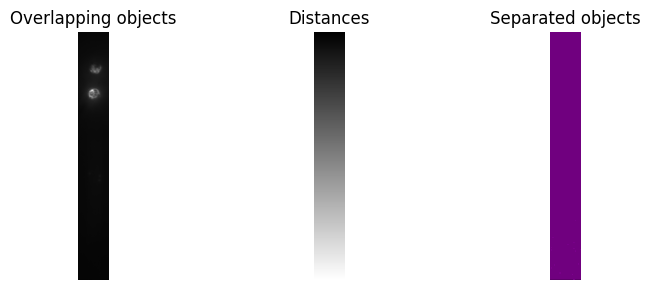

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image = fluorescent_image
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)


fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

(275, 2, 2035, 252)
Seed Point - Label ID: 1, Area: 4040 pixels, Centroid: (143, 310)
Seed Point - Label ID: 8, Area: 7234 pixels, Centroid: (127, 504)


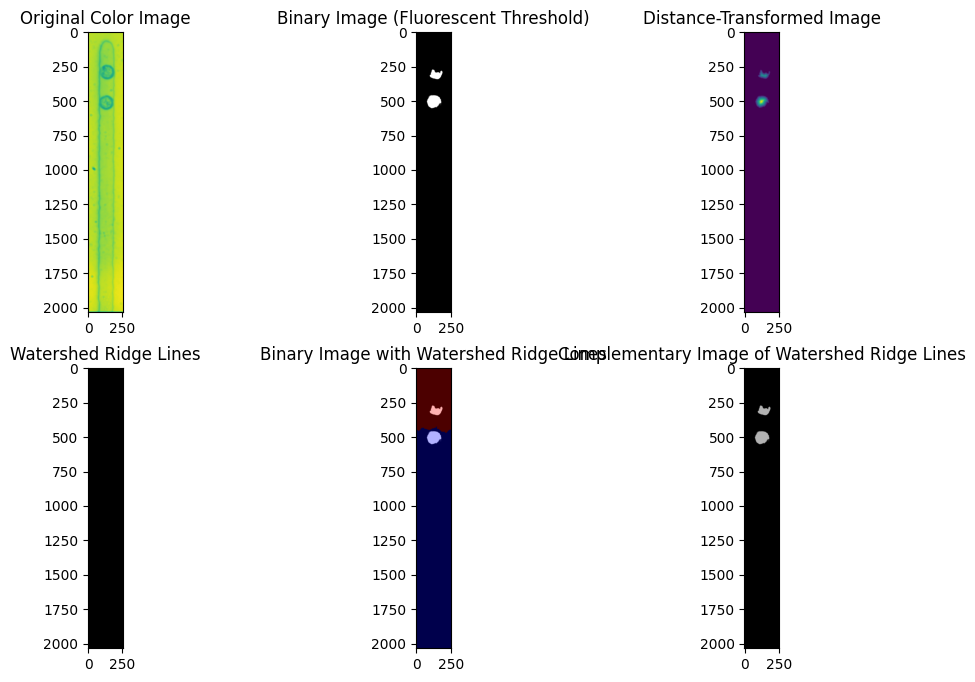

In [113]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tifffile
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import morphology, color

tifffile_image = tifffile.imread(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\trap_1_all_frames_series.tiff")
print(tifffile_image.shape)

# Load your fluorescent and brightfield images
fluorescent_image = tifffile_image[1, 1, :, :]
brightfield_image = tifffile_image[1, 0, :, :]

# Apply Otsu's thresholding to fluorescent image
_, binary_image = cv2.threshold(fluorescent_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
binary_image = binary_image.astype(np.uint8)
# Find cell locations and centroids
analysis = cv2.connectedComponentsWithStats(binary_image, 4, cv2.CV_32S)
(totalLabels, label_ids, values, centroids) = analysis

# Minimum area threshold for filtering
min_area_threshold = 100  # Adjust as needed

# Print area, label ID, and centroids for each label, filtered by area
for label in range(1, totalLabels):  # Start from 1 to skip background label
    area = values[label][4]
    if area >= min_area_threshold:
        centroid = tuple(map(int, centroids[label]))
        print(f"Seed Point - Label ID: {label}, Area: {area} pixels, Centroid: {centroid}")

# Create an empty marker image
markers = np.zeros_like(brightfield_image, dtype=np.int32)

# Assign labels as markers, filtered by area
for label in range(1, totalLabels):  # Start from 1 to skip background label
    area = values[label][4]
    if area >= min_area_threshold:
        markers[label_ids == label] = label

# Convert the marker image to 32-bit single-channel
markers = markers.astype(np.int32)

# Apply watershed segmentation using skimage on color brightfield image
segmentation = watershed(brightfield_image, markers)

# Ridge lines using distance transform
distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
local_max_location = peak_local_max(distance_transform, min_distance=1)
ridge_lines = morphology.skeletonize(segmentation == 0)

# Overlay ridge lines on the original binary image
overlay = color.label2rgb(segmentation, image=binary_image, bg_label=0, alpha=0.3, image_alpha=1, kind='overlay')

# Complementary image of watershed ridge lines superimposed on the binary image
complementary_overlay = color.label2rgb(ridge_lines, image=binary_image, bg_label=0, alpha=0.3, image_alpha=1, kind='overlay')

# Plotting
plt.figure(figsize=(12, 8))

# Original Color Image
plt.subplot(2, 3, 1)
plt.imshow(brightfield_image)
plt.title('Original Color Image')

# Binary Image (Fluorescent Image Thresholded)
plt.subplot(2, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image (Fluorescent Threshold)')

# Distance-Transformed Image
plt.subplot(2, 3, 3)
plt.imshow(distance_transform, cmap='viridis')
plt.title('Distance-Transformed Image')

# Watershed Ridge Lines
plt.subplot(2, 3, 4)
plt.imshow(ridge_lines, cmap='gray')
plt.title('Watershed Ridge Lines')

# Original Binary Image Overlaid with Watershed Ridge Lines
plt.subplot(2, 3, 5)
plt.imshow(overlay)
plt.title('Binary Image with Watershed Ridge Lines')

# Complementary Image of Watershed Ridge Lines Superimposed on Binary Image
plt.subplot(2, 3, 6)
plt.imshow(complementary_overlay)
plt.title('Complementary Image of Watershed Ridge Lines')

plt.show()


TESTING

(275, 2, 2035, 252)


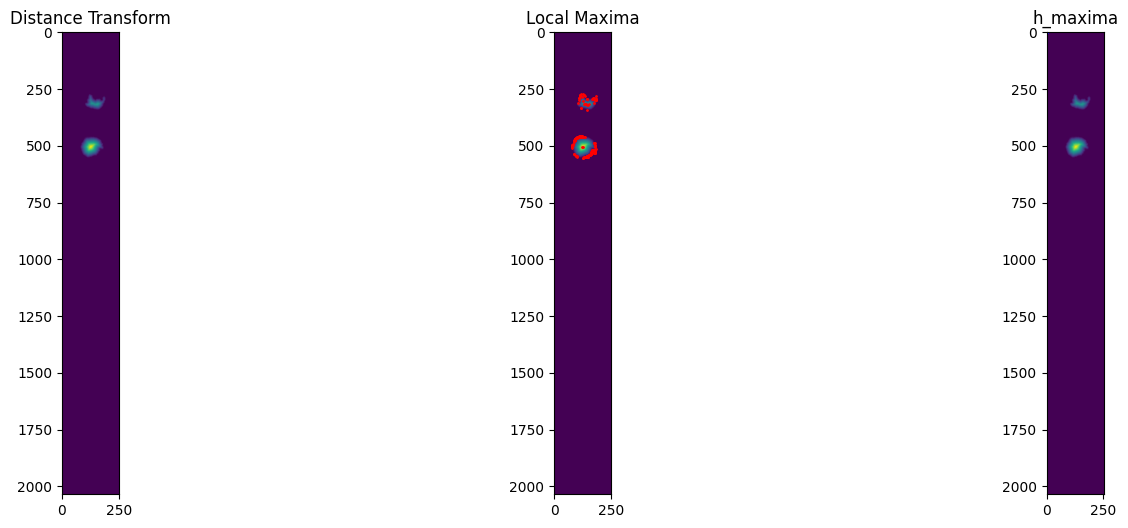

In [148]:
import cv2
import numpy as np
import tifffile
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import skimage.segmentation
import matplotlib.pyplot as plt
from skimage.morphology import extrema

# Load Tiff image
tifffile_image = tifffile.imread(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\trap_1_all_frames_series.tiff")
print(tifffile_image.shape)

# Load your fluorescent and brightfield images
fluorescent_image = tifffile_image[1, 1, :, :]
brightfield_image = tifffile_image[1, 0, :, :]

# Apply Otsu's thresholding
threshold = cv2.threshold(fluorescent_image, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
threshold = threshold.astype(np.uint8)

# Calculate distance transform
dist_transform = cv2.distanceTransform(threshold, cv2.DIST_L2, 3)

# Find local maxima
local_max_location = peak_local_max(dist_transform, min_distance=1)

# Find h_maxima
h = 0.1
h_maxima = extrema.h_maxima(dist_transform, h)

# Label the local maxima and h_maxima
markers_maxima, _ = ndi.label(local_max_location)
markers_h_maxima, _ = ndi.label(h_maxima)

# Visualize dist_transform, local maxima, and h_maxima
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display dist_transform
axes[0].imshow(dist_transform, cmap='viridis')
axes[0].set_title('Distance Transform')

# Display local maxima
axes[1].imshow(dist_transform, cmap='viridis')
axes[1].plot(local_max_location[:, 1], local_max_location[:, 0], 'ro', markersize=1)
axes[1].set_title('Local Maxima')

# Display h_maxima
axes[2].imshow(dist_transform, cmap='viridis')
axes[2].plot(h_maxima[:, 1], h_maxima[:, 0], 'bo', markersize=1)
axes[2].set_title('h_maxima')

plt.show()


In [139]:
import napari

viewer = napari.Viewer()

# Add the tiff stack as a 3D layer
viewer.add_image(dist_transform, name="dist")
viewer.add_image(local_max_location, name="lcl")
viewer.add_image(markers, name="markers")
viewer.add_image(fluorescent_image, name="FI")

<Image layer 'FI' at 0x19a98bdcac0>